In [65]:
#importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error


color_pal = sns.color_palette()
plt.style.use('ggplot')

In [66]:
#loading the data
df = pd.read_csv('..\Hourly-Energy-Consumption-Forecast/COMED_hourly.csv')
df= df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

,COMED_MW
Datetime,
2011-12-31 01:00:00,9970.0
2011-12-31 02:00:00,9428.0
2011-12-31 03:00:00,9059.0
2011-12-31 04:00:00,8817.0
2011-12-31 05:00:00,8743.0


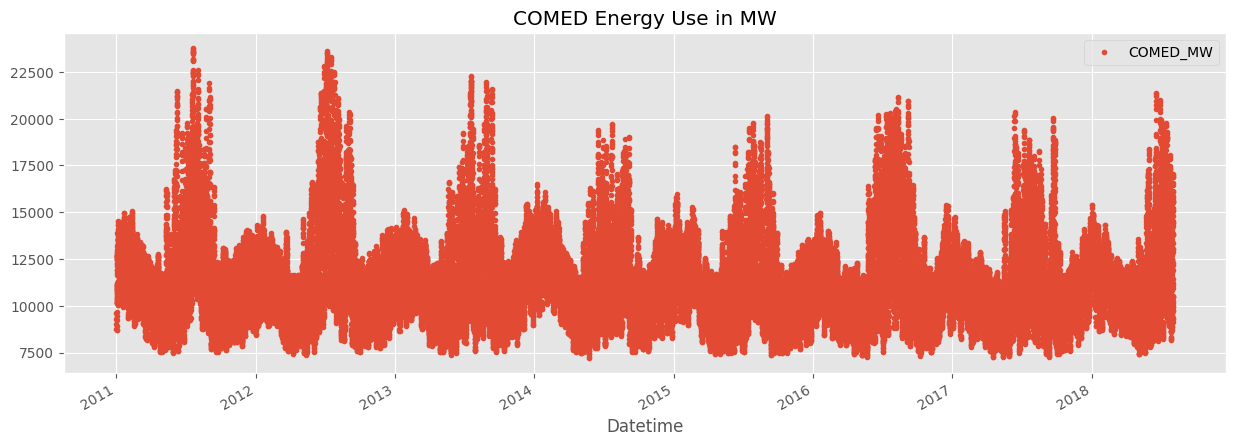

In [67]:
#visualizing the data
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='COMED Energy Use in MW')
plt.show()

In [68]:
df.info

<bound method DataFrame.info of                      COMED_MW
Datetime                     
2011-12-31 01:00:00    9970.0
2011-12-31 02:00:00    9428.0
2011-12-31 03:00:00    9059.0
2011-12-31 04:00:00    8817.0
2011-12-31 05:00:00    8743.0
...                       ...
2018-01-01 20:00:00   13858.0
2018-01-01 21:00:00   13758.0
2018-01-01 22:00:00   13627.0
2018-01-01 23:00:00   13336.0
2018-01-02 00:00:00   12816.0

[66497 rows x 1 columns]>

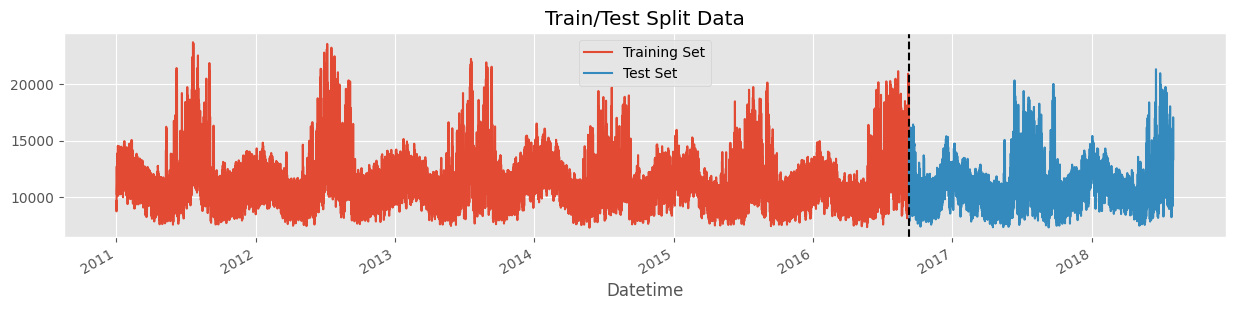

In [69]:
#Train/Test Split:
"""We have data from "2011-01-01 01:00:00" till "2018-08-03 00:00:00" and data is hourly in a period 7-years 8-months & 3-days, corresponding to 66,497 data input. We will divide the data to about 75% to 25% for train/test split.
"""
train = df.loc[df.index < '2016-09-09']
test = df.loc[df.index >= '2016-09-09']

fig, ax = plt.subplots(figsize=(15, 3))
train.plot(ax=ax, label='Training Set', title='Train/Test Split Data')
test.plot(ax=ax, label='Test Set')
ax.axvline('2016-09-09', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [70]:
#tss = TimeSeriesSplit(n_splits=5, test_size=24*365*2, gap=24)
#df = df.sort_index()

In [71]:
#Feature creation:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

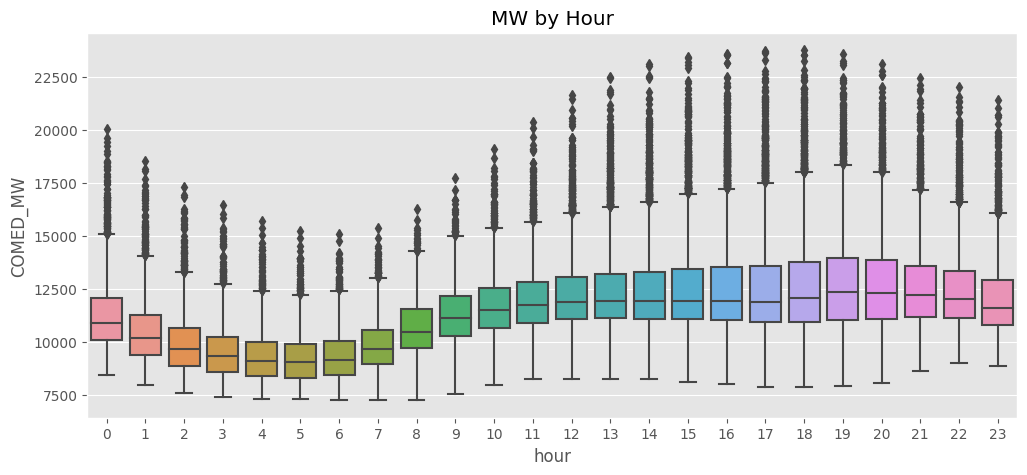

In [72]:
#Visualize the Feature/Target Relationship
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=df, x='hour', y='COMED_MW')
ax.set_title('MW by Hour')
plt.show()

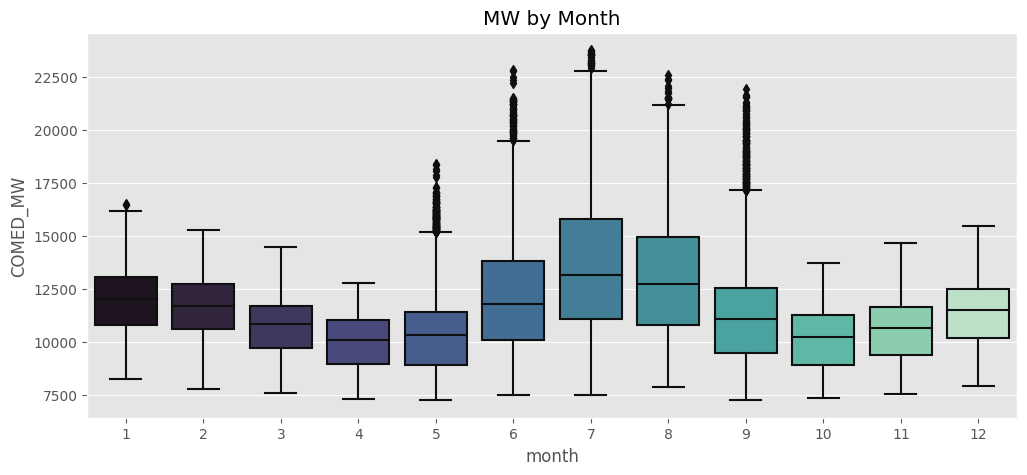

In [73]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=df, x='month', y='COMED_MW', palette='mako')
ax.set_title('MW by Month')
plt.show()

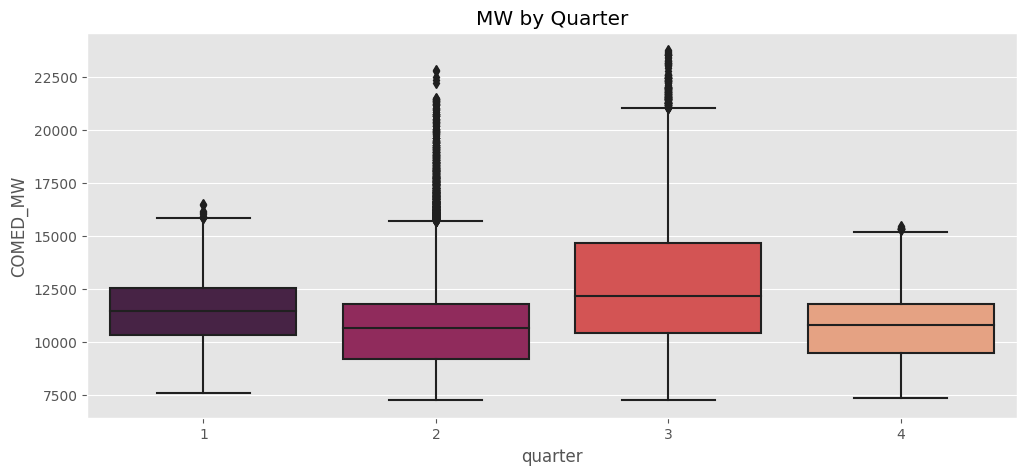

In [74]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data=df, x='quarter', y='COMED_MW', palette='rocket')
ax.set_title('MW by Quarter')
plt.show()

In [75]:
#Model Creation:
train = create_features(train)
test = create_features(test)

features = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
target = 'COMED_MW'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [76]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=10000,
                       early_stopping_rounds=80,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.003)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[12:33:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11720.13882	validation_1-rmse:11295.44207
[100]	validation_0-rmse:8762.86307	validation_1-rmse:8340.71503
[200]	validation_0-rmse:6580.17811	validation_1-rmse:6177.34676
[300]	validation_0-rmse:4984.19346	validation_1-rmse:4602.41796
[400]	validation_0-rmse:3830.38332	validation_1-rmse:3469.83831
[500]	validation_0-rmse:3007.46942	validation_1-rmse:2671.84476
[600]	validation_0-rmse:2429.49105	validation_1-rmse:2130.23961
[700]	validation_0-rmse:2031.07685	validation_1-rmse:1783.88708
[800]	validation_0-rmse:1764.91673	validation_1-rmse:1575.18964
[900]	validation_0-rmse:1589.89651	validation_1-rmse:1457.73459
[1000]	validation_0-rmse:1478.70905	validation_1-rmse:1396.09432
[1100]	validation_0-rmse:1406.29908	validation_1-rmse:1363.90710

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=80, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.003, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto', ...)

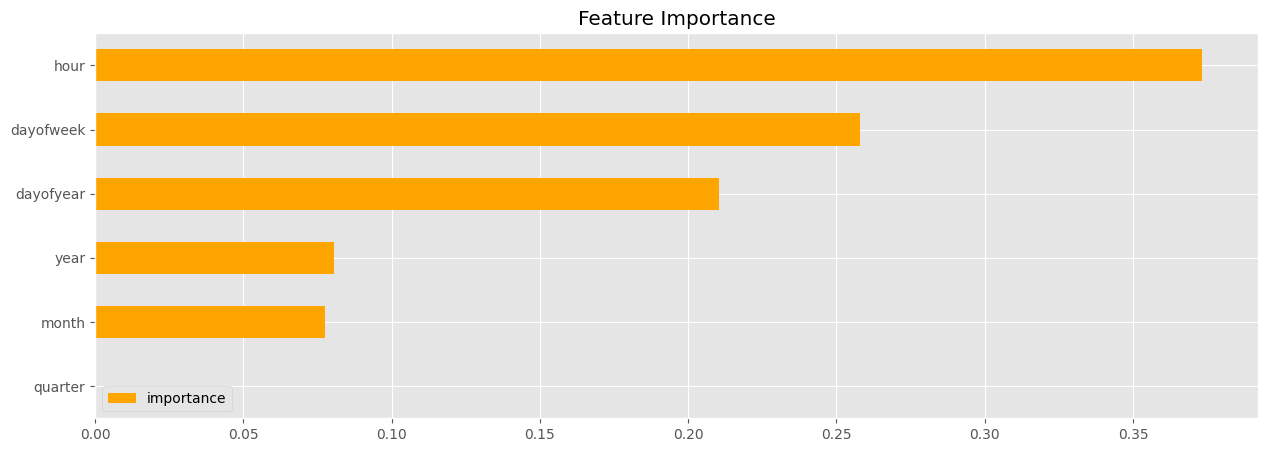

In [77]:
feature_importance = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
feature_importance.sort_values('importance').plot(figsize=(15,5) , kind='barh', title='Feature Importance', color='orange' )
plt.show()

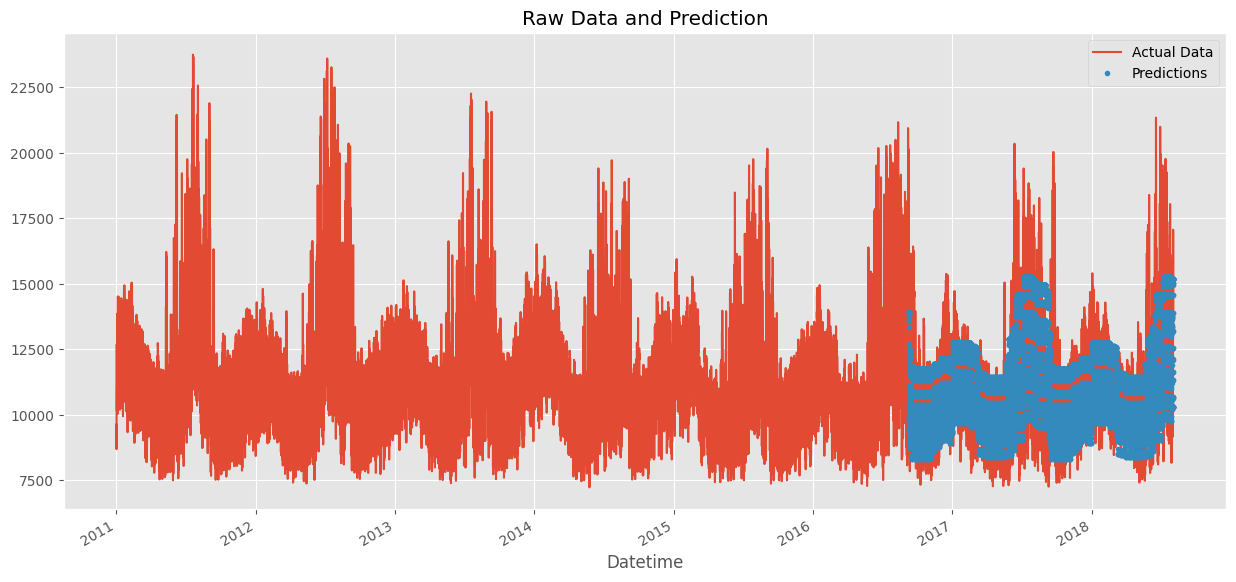

In [78]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['COMED_MW']].plot(figsize=(15, 7))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [79]:
#Using the model for future dates
#Steps: 1-Retrain on all data ; 2-add future date ranges ; 3-run the ML model though

df = create_features(df)

features = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
target = 'COMED_MW'

X_all = df[features]
y_all = df[target]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=10000,
                       objective='reg:linear',
                       early_stopping_rounds=50,
                       max_depth=3,
                       learning_rate=0.003)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=250)

[12:33:14] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11615.46982
[250]	validation_0-rmse:5668.96895
[500]	validation_0-rmse:2985.32996
[750]	validation_0-rmse:1880.63781
[1000]	validation_0-rmse:1482.59035
[1250]	validation_0-rmse:1351.51570
[1500]	validation_0-rmse:1298.56951
[1750]	validation_0-rmse:1264.56284
[2000]	validation_0-rmse:1245.14538
[2250]	validation_0-rmse:1230.83015
[2500]	validation_0-rmse:1218.90372
[2750]	validation_0-rmse:1208.56436
[3000]	validation_0-rmse:1198.49022
[3250]	validation_0-rmse:1190.40203
[3500]	validation_0-rmse:1182.53024
[3750]	validation_0-rmse:1175.65751
[4000]	validation_0-rmse:1168.31739
[4250]	validation_0-rmse:1161.70834
[4500]	validation_0-rmse:1154.95187
[4750]	validation_0-rmse:1150.71271
[5000]	validation_0-rmse:1145.87420
[5250]	validation_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.003, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto', ...)

In [80]:
df.index.max()


Timestamp('2018-08-03 00:00:00')

In [81]:
# Create future dataframe
future = pd.date_range('2018-08-03','2024-08-03', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)

In [82]:
future_w_features = df_and_future.query('isFuture').copy()

In [83]:
future_w_features['pred'] = reg.predict(future_w_features[features])

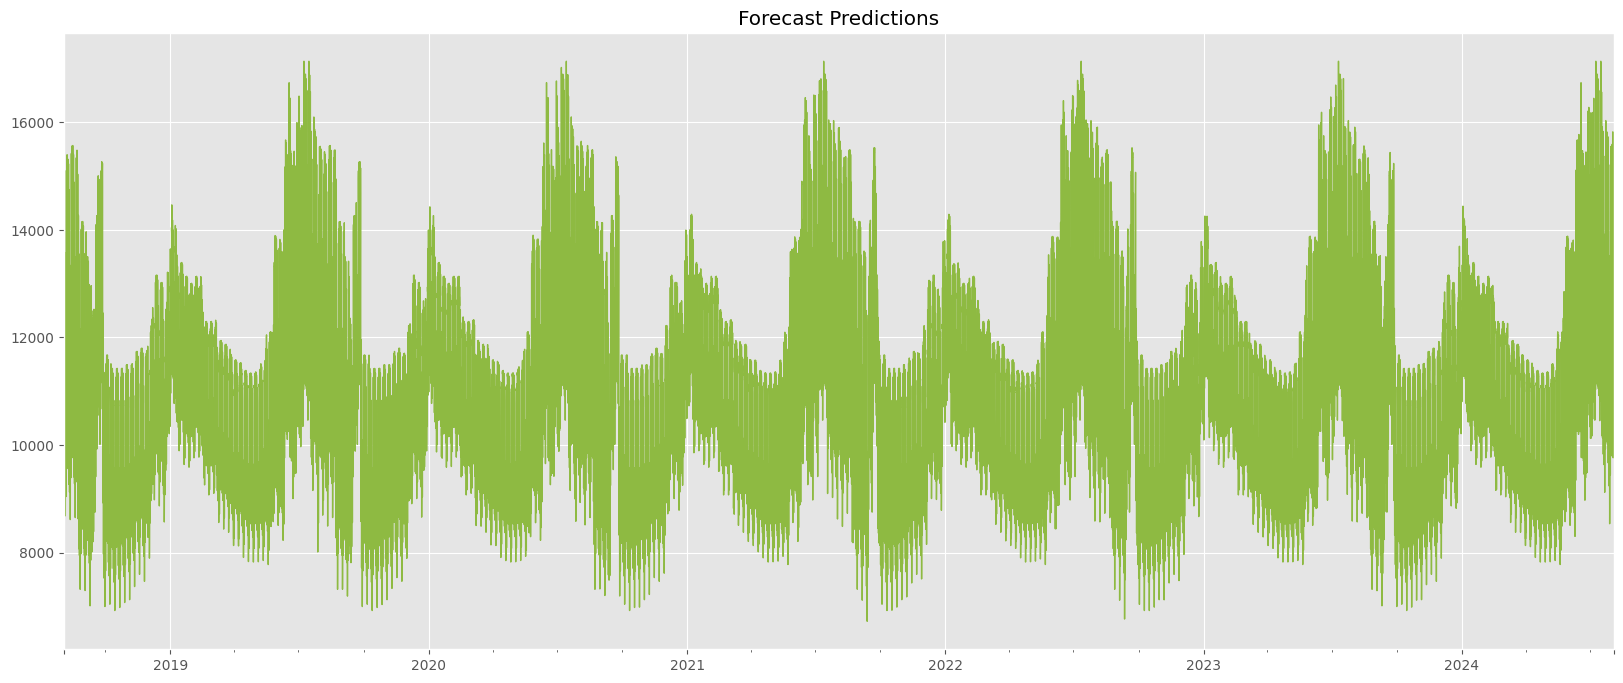

In [84]:
future_w_features['pred'].plot(figsize=(20, 8),
                               color=color_pal[5],
                               ms=1,
                               lw=1,
                               title='Forecast Predictions')
plt.show()

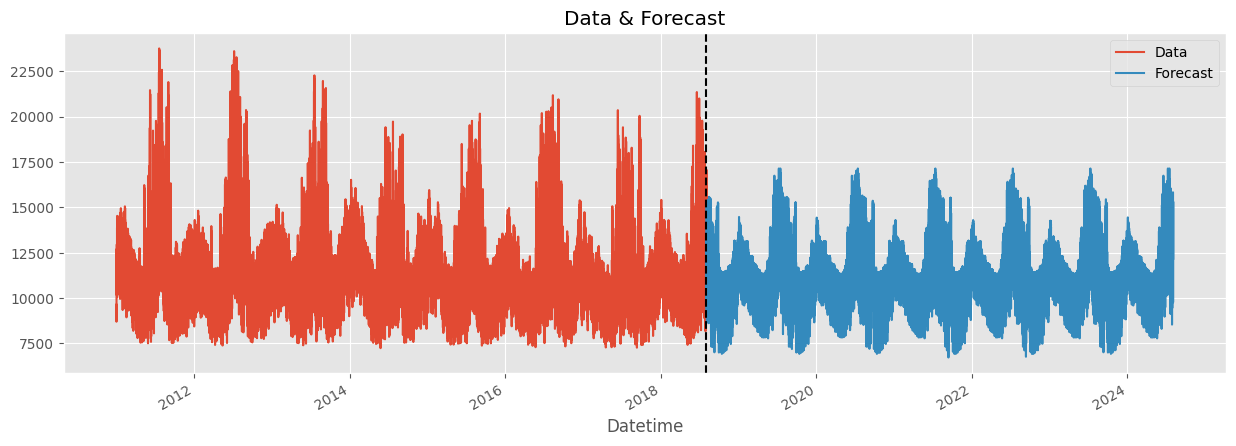

In [85]:
fig, ax = plt.subplots(figsize=(15, 5))
df['COMED_MW'].plot(ax=ax, label='Data', title='Data & Forecast')
future_w_features['pred'].plot(ax=ax, label='Forecast')
ax.axvline('2018-08-03', color='black', ls='--')
ax.legend(['Data', 'Forecast'])
plt.show()

In [86]:
#Score
score = np.sqrt(mean_squared_error(test['COMED_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.4f}')


RMSE Score on Test set: 1342.5605
